<a href="https://colab.research.google.com/github/ryali93/IA_notebooks/blob/master/IA_Notebook_2%20-%20Ataques%20Adversarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 390.6MB 52kB/s 
     |████████████████████████████████| 460kB 39.7MB/s 
     |████████████████████████████████| 3.8MB 26.2MB/s 


In [0]:
device_name = tf.test.gpu_device_name()

In [11]:
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import numpy as np

In [0]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K

In [0]:
iv3 = InceptionV3()

In [15]:
print(iv3.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [0]:
from keras.preprocessing import image

In [17]:
x = image.img_to_array(image.load_img("cat.jpg", target_size=(299, 299)))

# Cambio de rango, 0-255 -> -1, 1
x /= 255
x -= 0.5
x *= 2

x = x.reshape([1, x.shape[0], x.shape[1], x.shape[2]])

y = iv3.predict(x)

print(x.shape)

(1, 299, 299, 3)


In [18]:
decode_predictions(y)

[[('n02123045', 'tabby', 0.7723467),
  ('n02124075', 'Egyptian_cat', 0.16650018),
  ('n02123159', 'tiger_cat', 0.040556967),
  ('n04367480', 'swab', 0.0003339254),
  ('n04584207', 'wig', 0.00031960622)]]

## Ataques adversarios

In [0]:
inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output

target_class = 951 # Lemon

loss = out_layer[0, target_class]

grad = K.gradients(loss, inp_layer)[0]

optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])

adv = np.copy(x)

cost = 0.0

with tf.device('/gpu:0'):
  while cost < 0.95:
      gr, cost = optimize_gradient([adv, 0]) # 0: modo testing
      adv += gr
      print("Target cost: ", cost)

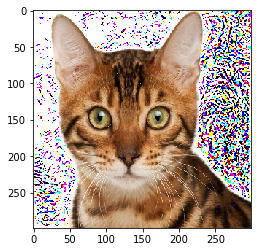

In [20]:
adv /= 2
adv += 0.5
adv *= 255

plt.imshow(adv[0].astype(np.uint8))
plt.show()

In [0]:
from PIL import Image
im = Image.fromarray(adv[0].astype(np.uint8))
im.save("hacked.png")

In [0]:
inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output

target_class = 951

loss = out_layer[0, target_class]

grad = K.gradients(loss, inp_layer)[0]

optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])

adv = np.copy(x)

pert = 0.01

max_pert = x + 0.01
min_pert = x - 0.01

cost = 0.0

with tf.device('/gpu:0'):
  while cost < 0.95:
      gr, cost = optimize_gradient([adv, 0]) # 0: modo testing
      min_pert+= gr

      adv = np.clip(adv, min_pert, max_pert)
      adv = np.clip(adv, -1, 1)

      print("Lemon cost: ", cost)

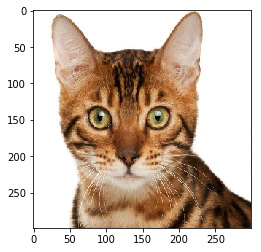

In [25]:
adv /= 2
adv += 0.5
adv *= 255

plt.imshow(adv[0].astype(np.uint8))
plt.show()

In [0]:
from PIL import Image
im = Image.fromarray(adv[0].astype(np.uint8))
im.save("hacked_1.png")

Comprobando si lo reconoce como gato

In [29]:
x = image.img_to_array(image.load_img("hacked_1.png", target_size=(299, 299)))

# Cambio de rango, 0-255 -> -1, 1
x /= 255
x -= 0.5
x *= 2

x = x.reshape([1, x.shape[0], x.shape[1], x.shape[2]])

y = iv3.predict(x)

print(x.shape)

(1, 299, 299, 3)


In [30]:
decode_predictions(y)

[[('n07749582', 'lemon', 0.94139767),
  ('n02123159', 'tiger_cat', 0.0025316211),
  ('n02123045', 'tabby', 0.0023138146),
  ('n07718472', 'cucumber', 0.0020315968),
  ('n04584207', 'wig', 0.001882954)]]

Agradecimientos al canal DOTCSV en [youtube](https://www.youtube.com/channel/UCy5znSnfMsDwaLlROnZ7Qbg)